In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import itertools

In [2]:
df = pd.read_csv('table_for_prediction_updated.csv')

In [3]:
def get_max(lst):
    return sorted(lst)[int(len(lst) * .98)] # get rid of outliers, hacky

def get_combination_string(combination, metrics):
    output = ['{:.2f} * {}'.format(c, m)  for c, m in zip(combination, metrics)]
    return ' + '.join(output)

def bins_counts_overlap(bins_counts):
    gyor_val_combinations = itertools.combinations(bins_counts.keys(), 2)
    comb_to_jaccard = {}
    for comb in gyor_val_combinations:
        bins_A = bins_counts[comb[0]]
        bins_B = bins_counts[comb[1]]
        min_idx = min(min(bins_A), min(bins_B))
        max_idx = max(max(bins_A), max(bins_B))
        all_overlap = 0
        all_unique = 0
        for i in range(min_idx, max_idx + 1):
            A_count = bins_A.count(i)
            B_count = bins_B.count(i)
            overlap = min(A_count, B_count)
            unique = max(A_count, B_count) - overlap
            all_overlap += overlap
            all_unique += unique
        comb_to_jaccard[comb] = all_overlap / (all_overlap + all_unique)
    return comb_to_jaccard

In [4]:
def plot_linear_combinations(grade, metrics=['WCPM', 'Acc4'], grain=4):
    ct = 1
    df_grade = df.loc[df.Grade == grade].fillna(0)
    df_grade = df_grade.copy(deep=True)
    for metric in metrics:
        df_grade[metric + '_scaled'] = np.interp(
            df_grade[metric], 
            (df_grade[metric].min(), get_max(df_grade[metric])), 
            (0, 1))
    intervals = list(np.linspace(0, 2, grain))
    df_values_submatrix = np.array(df_grade[[metric + '_scaled' for metric in metrics]])
    interval_combinations = itertools.product(*[intervals for _ in range(len(metrics))])
    comb_to_average_jaccard = {}
    for combination in interval_combinations:
        if 0 in combination:
            continue
        combination_vector = np.array(combination).reshape((len(combination), 1))
        df_grade['lin_comb'] = df_values_submatrix @ combination_vector
        plt.figure(figsize=(5, 3))
        
        lin_comb_min, lin_comb_max = min(df_grade.lin_comb), max(df_grade.lin_comb)
        bin_step = .2
        bins = [lin_comb_min - 0.001 + i * bin_step for i in range(0, int((lin_comb_max - lin_comb_min) / bin_step) + 2)]
        bins_counts = {}
        
        for gyor_val, gyor_color in zip(
                [3, 2, 1, 0], 
                ['lightgreen', 'gold', 'darkorange', 'firebrick']):
            df_grade_selected = df_grade.loc[df_grade.gyorJ == gyor_val]
            binned_lin_comb = np.digitize(df_grade_selected.lin_comb, bins, right=True)
            bins_counts[gyor_val] = sorted(binned_lin_comb)
            sns.distplot(df_grade_selected.lin_comb, color=gyor_color, hist_kws=dict(alpha=.2))\
                .set_title(grade + '\n' + get_combination_string(combination, metrics))
        jaccards = bins_counts_overlap(bins_counts)
        avg_jaccard = np.mean([y for x, y in jaccards.items()])
        comb_to_average_jaccard[get_combination_string(combination, metrics)] = avg_jaccard
    return sorted([(comb, comb_val) for comb, comb_val in comb_to_average_jaccard.items()], key=lambda xy: xy[1])[0]

/Users/ycm/opt/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


('2.00 * WCPM + 1.33 * Acc4 + 0.67 * Comp + 2.00 * AvgSpan',
 0.17323457120578753)

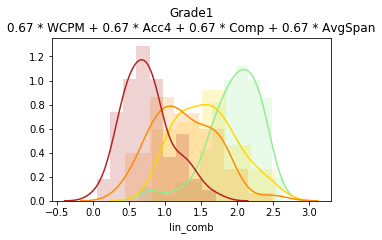

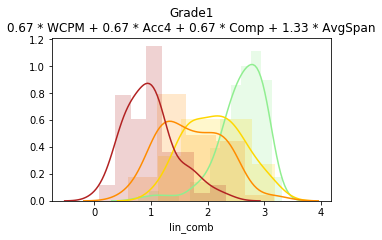

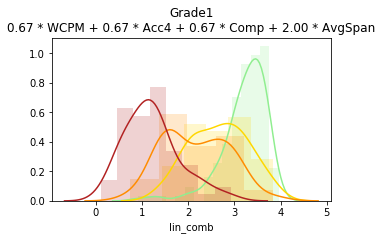

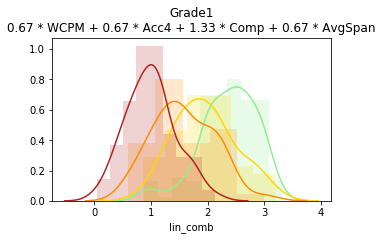

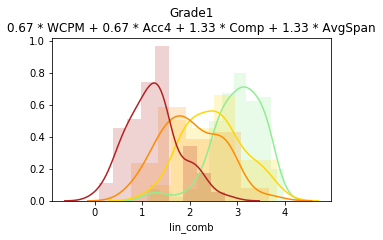

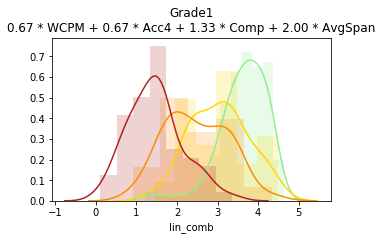

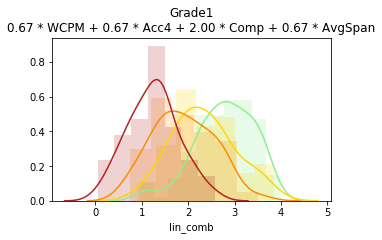

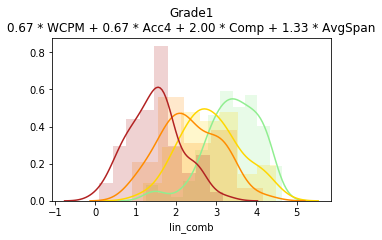

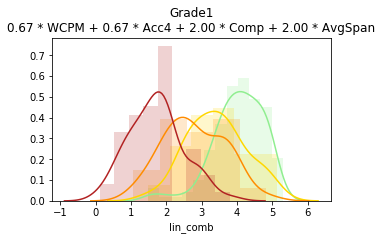

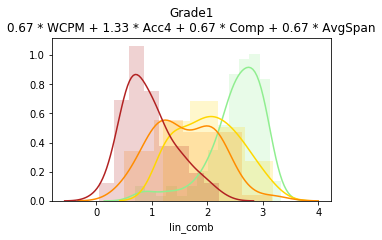

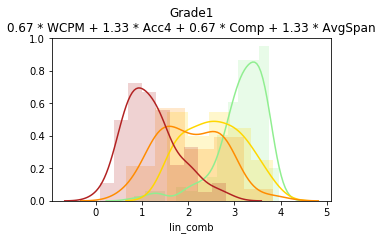

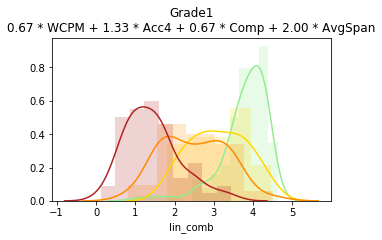

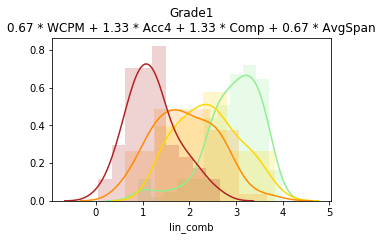

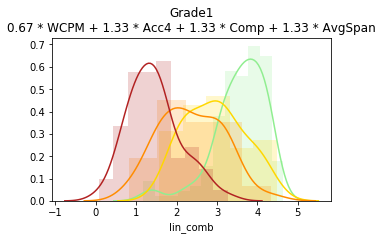

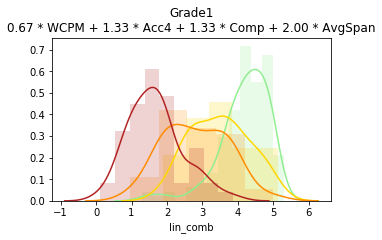

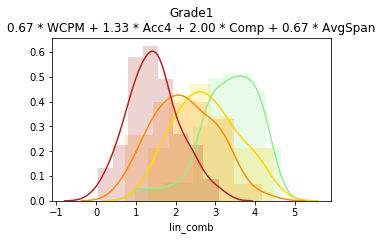

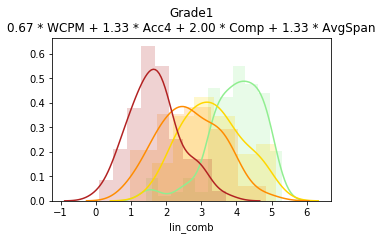

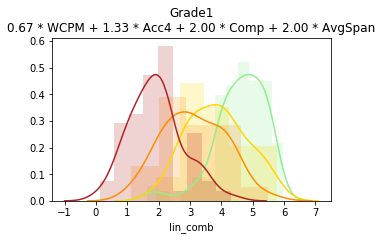

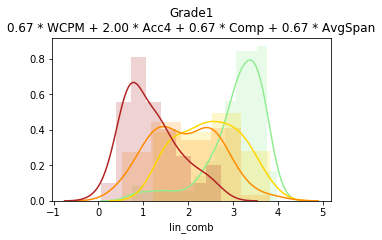

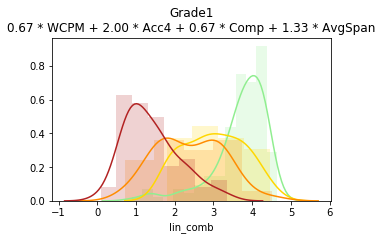

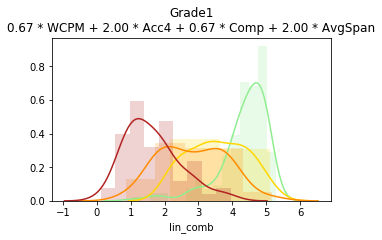

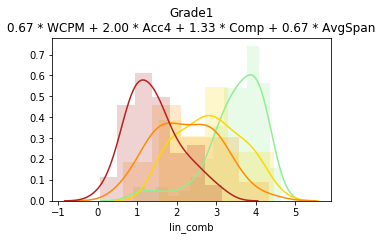

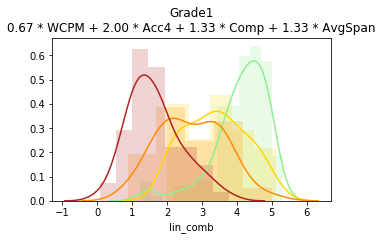

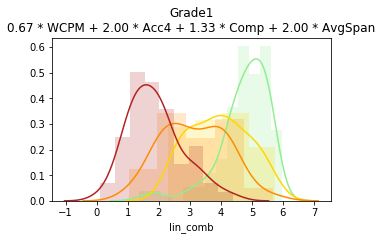

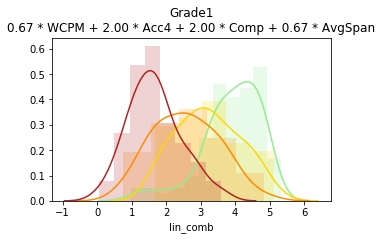

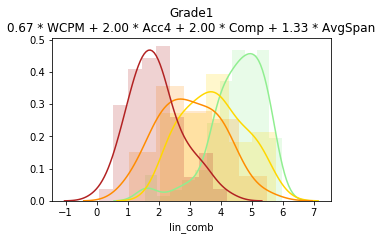

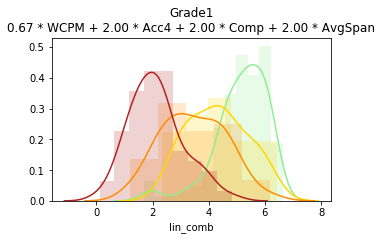

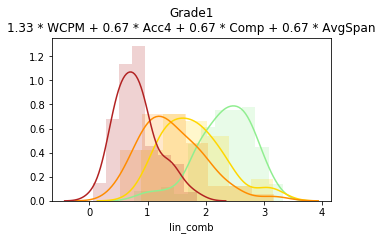

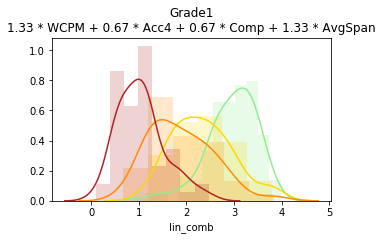

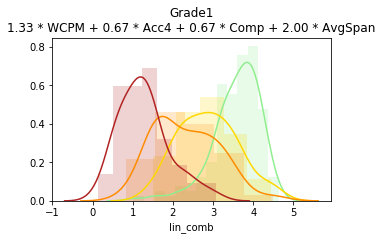

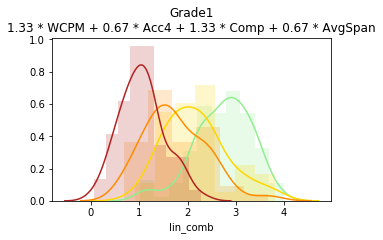

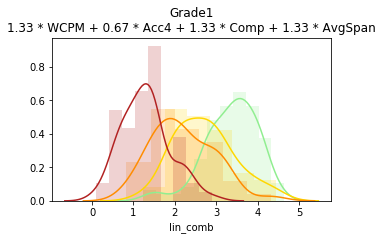

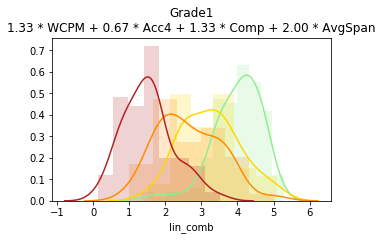

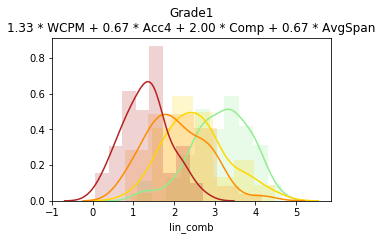

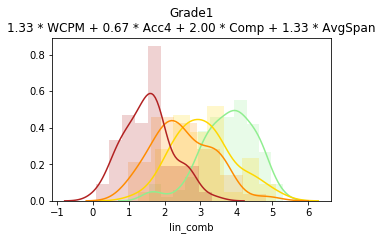

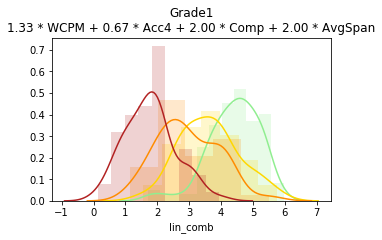

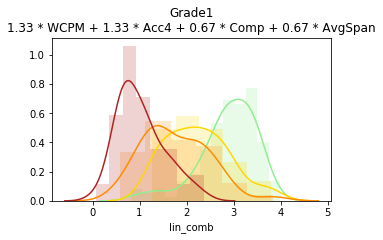

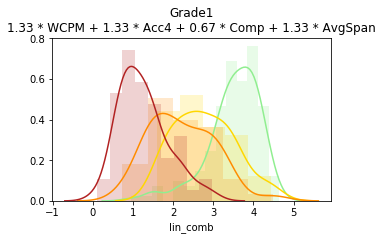

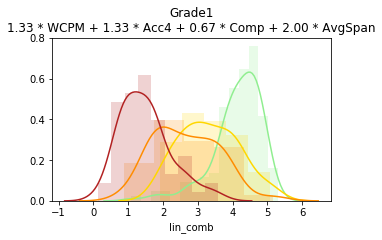

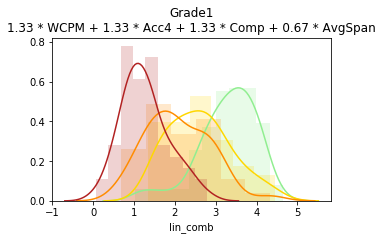

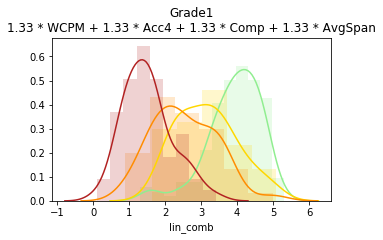

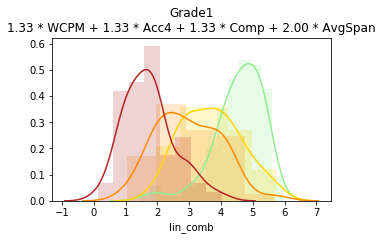

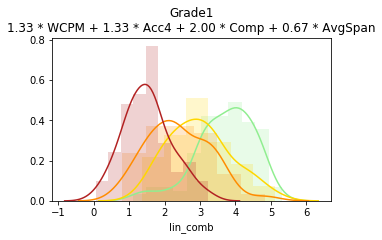

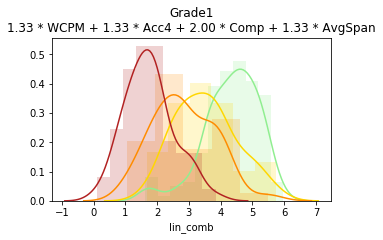

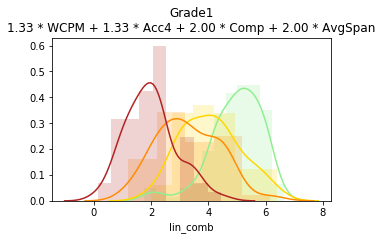

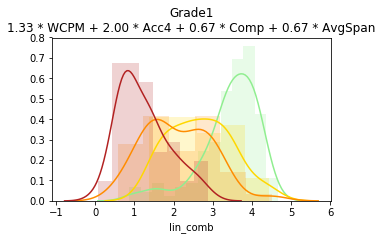

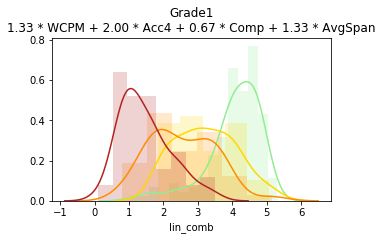

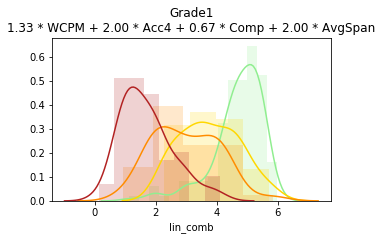

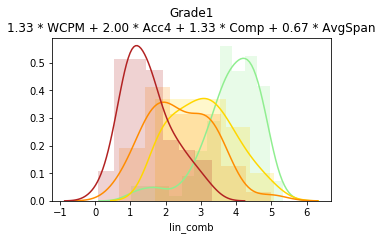

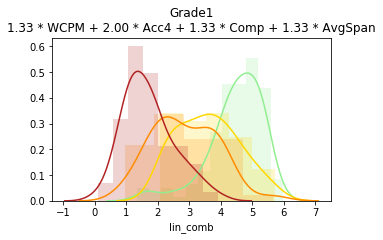

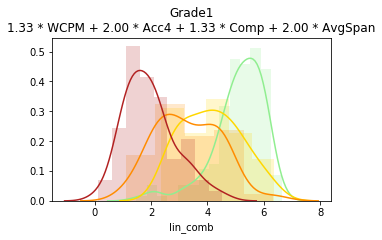

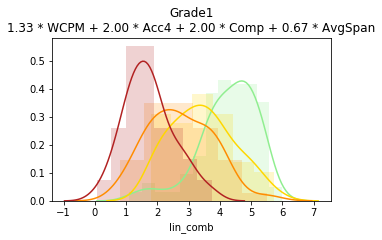

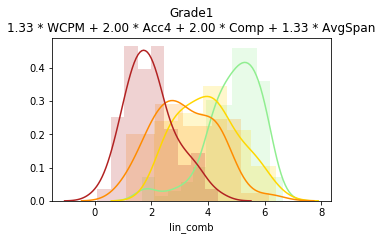

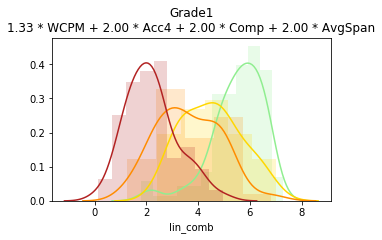

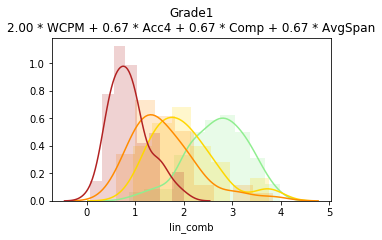

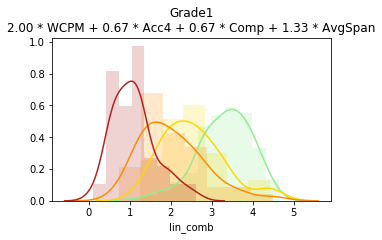

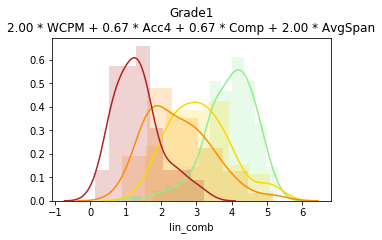

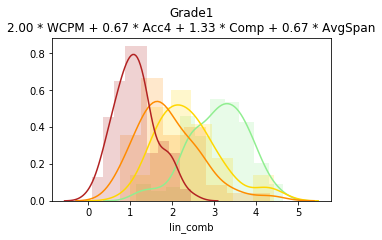

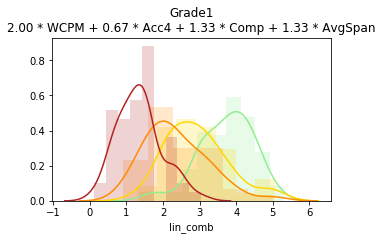

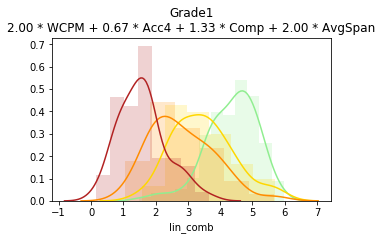

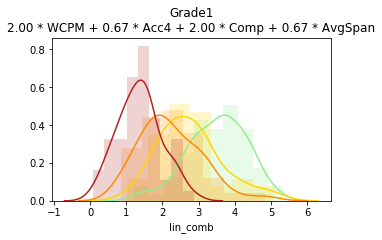

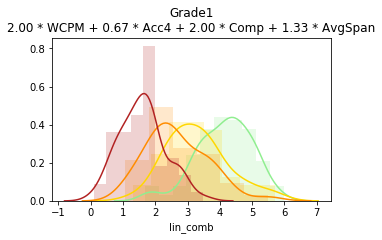

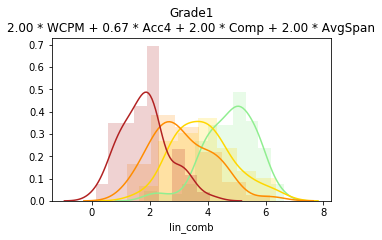

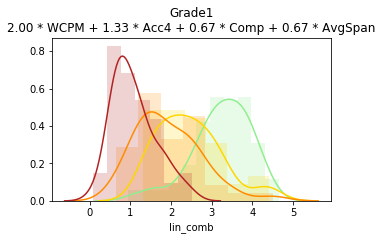

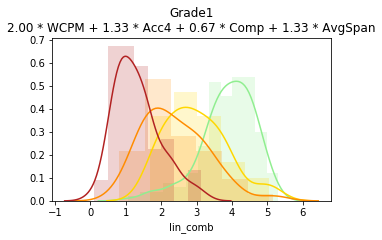

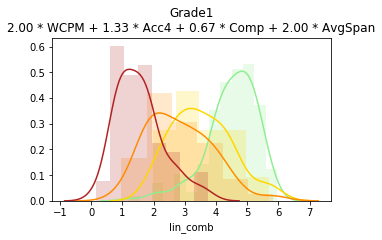

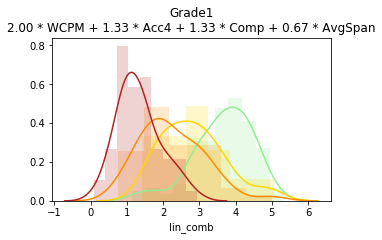

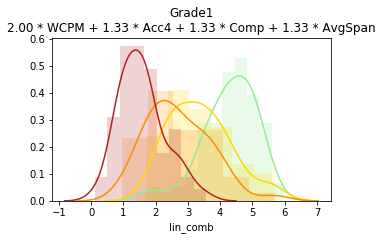

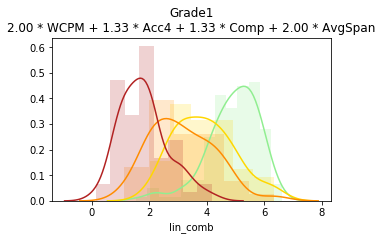

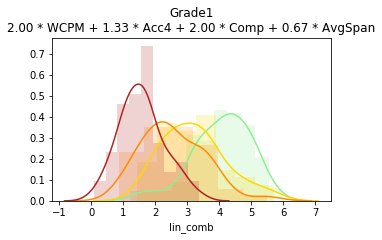

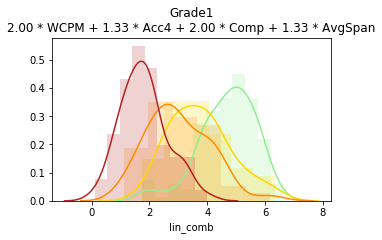

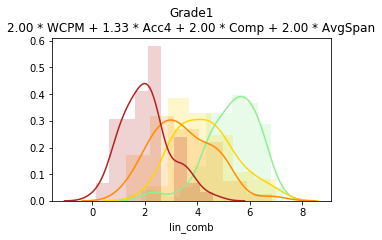

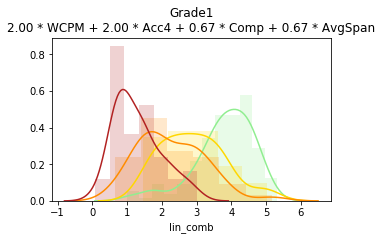

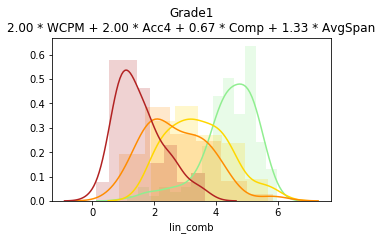

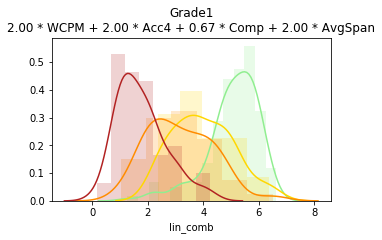

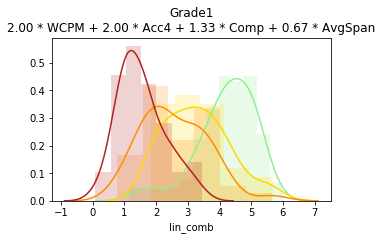

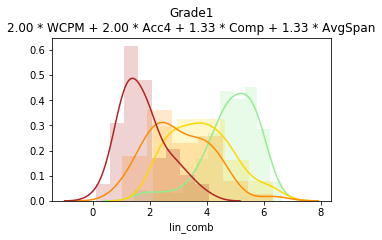

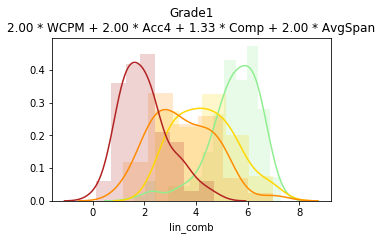

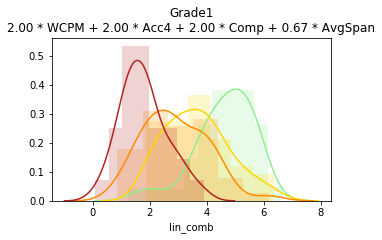

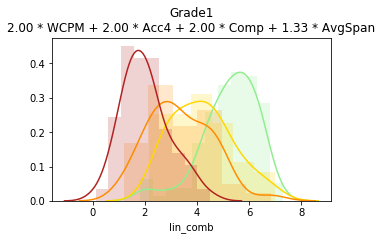

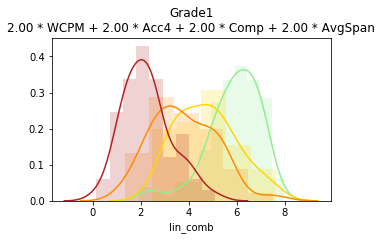

In [5]:
comb_to_average_jaccard = plot_linear_combinations('Grade1', metrics=['WCPM', 'Acc4', 'Comp', 'AvgSpan'], grain=4)
comb_to_average_jaccard

('2.00 * WCPM + 2.00 * Acc4 + 1.33 * Comp + 2.00 * AvgSpan',
 0.10082808490339612)

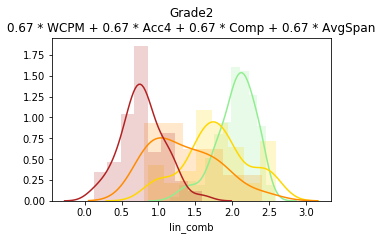

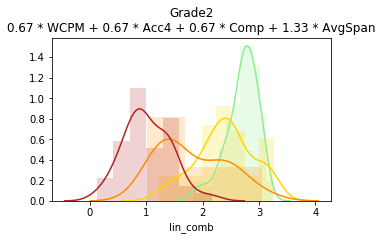

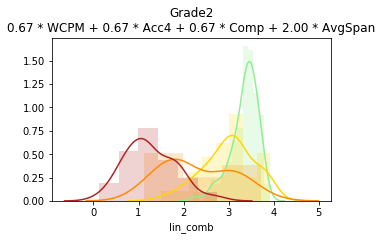

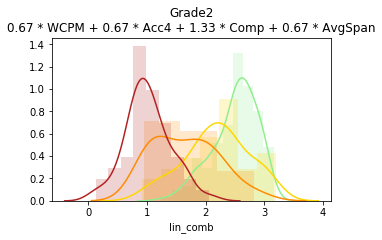

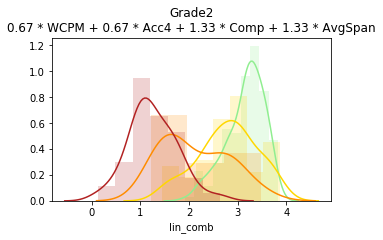

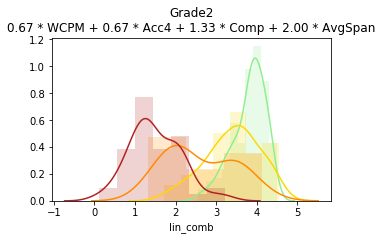

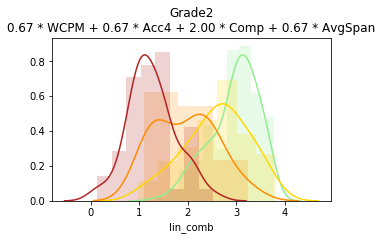

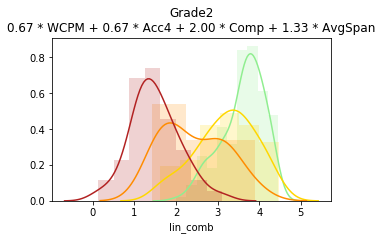

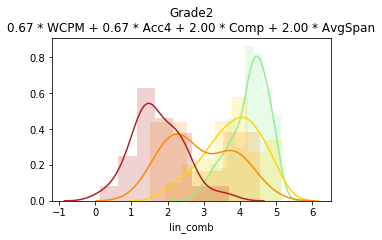

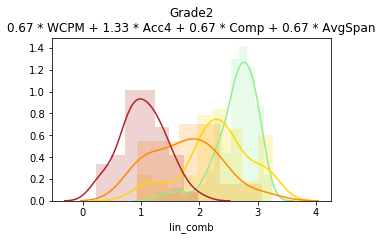

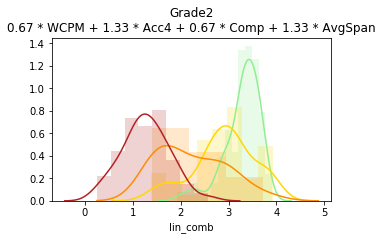

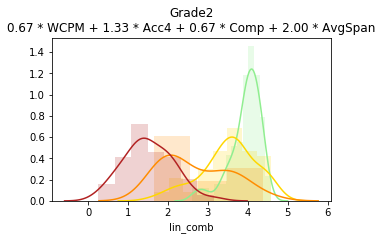

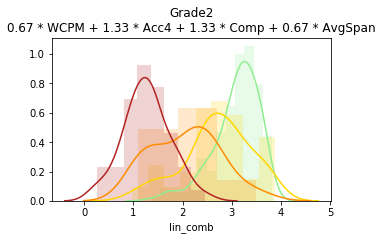

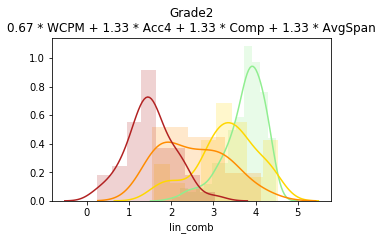

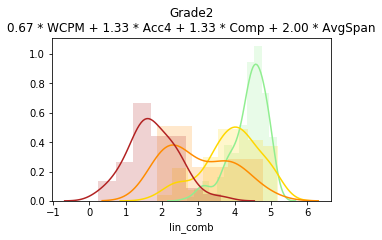

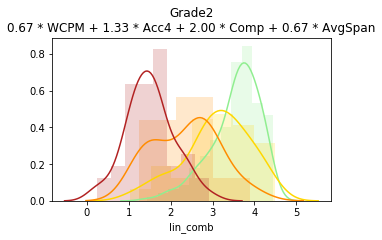

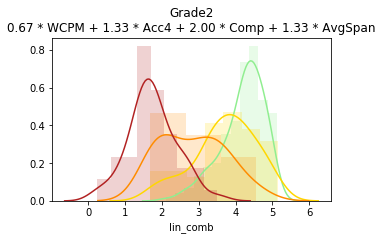

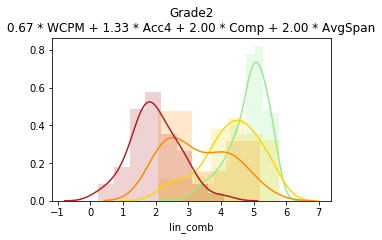

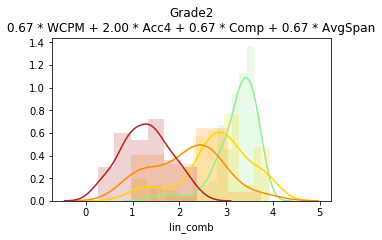

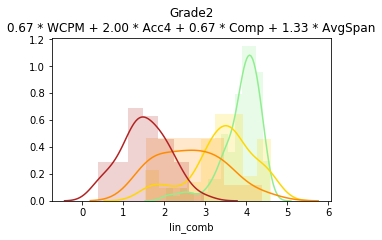

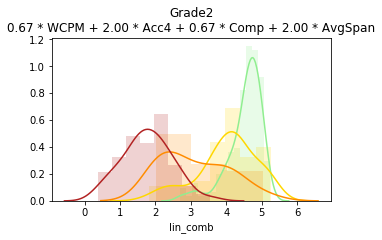

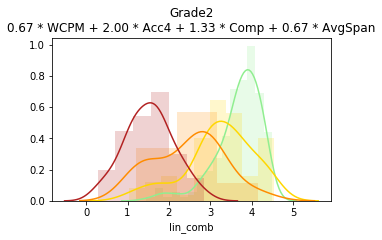

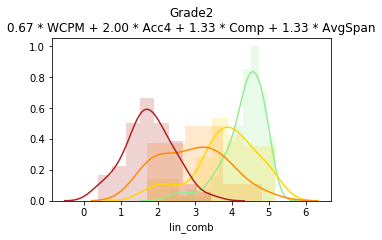

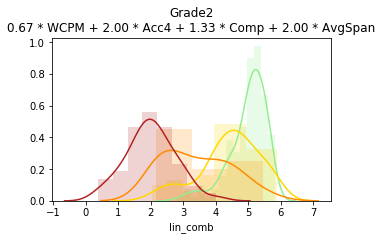

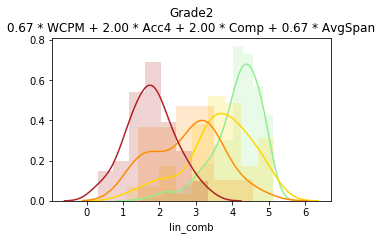

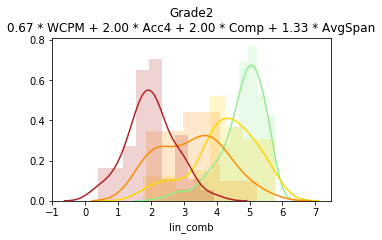

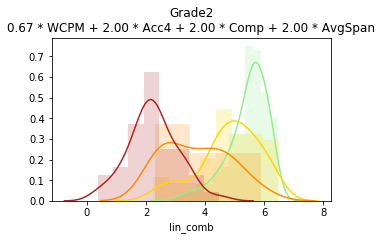

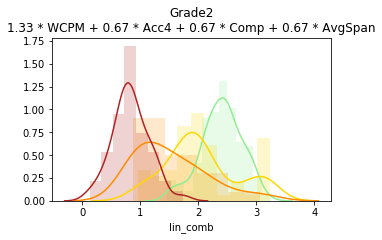

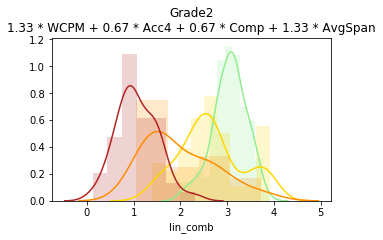

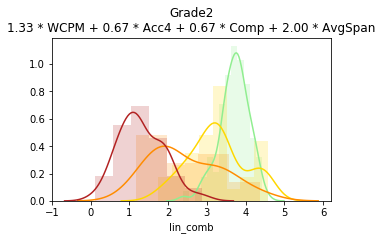

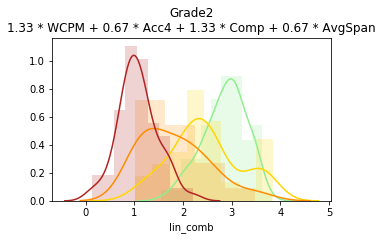

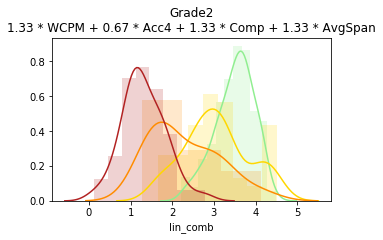

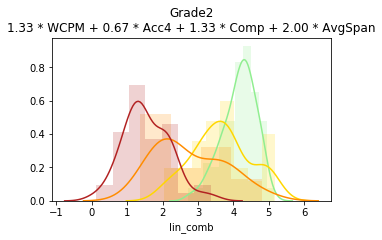

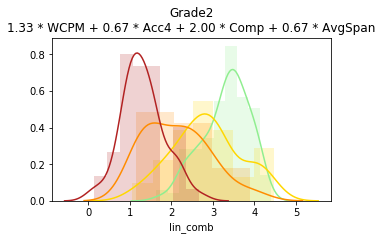

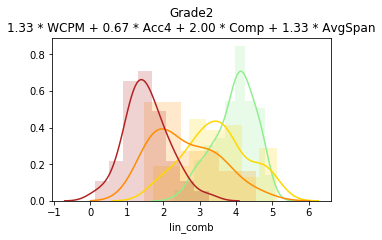

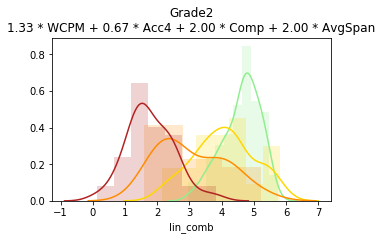

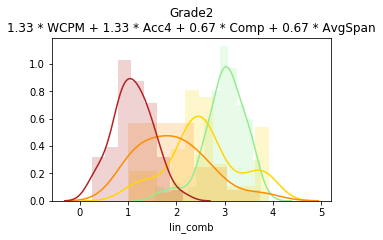

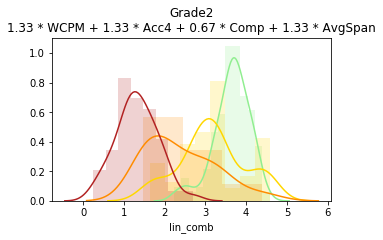

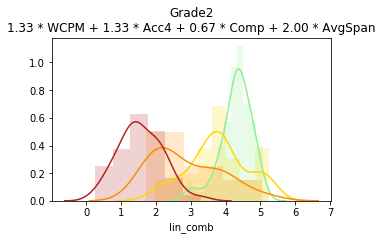

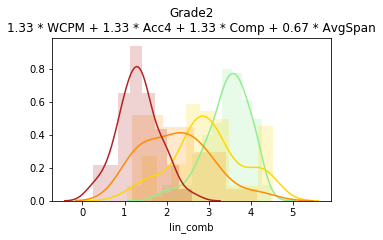

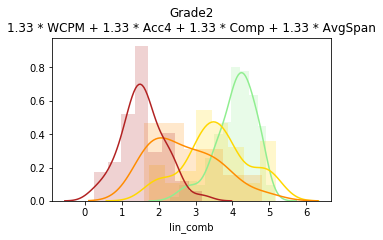

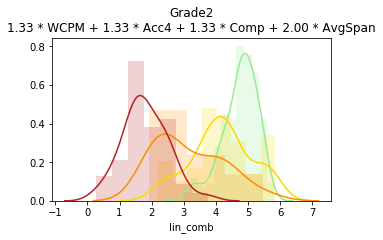

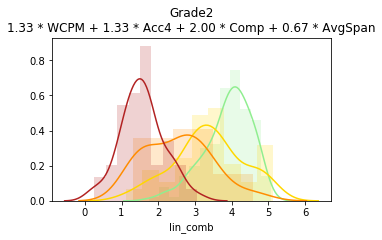

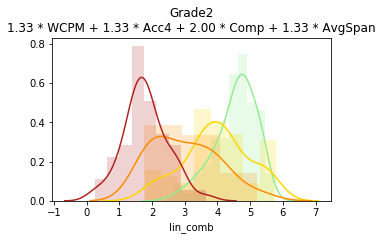

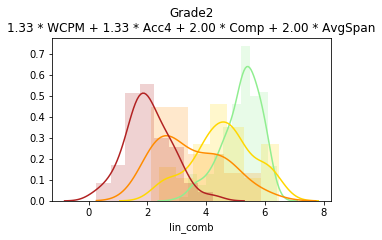

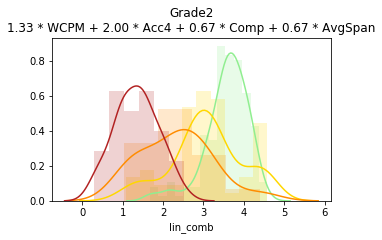

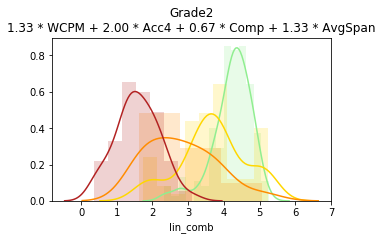

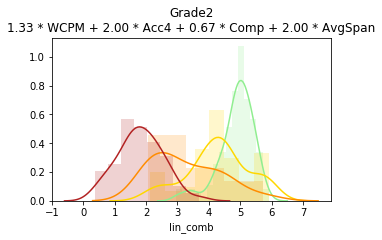

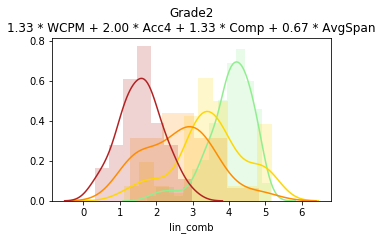

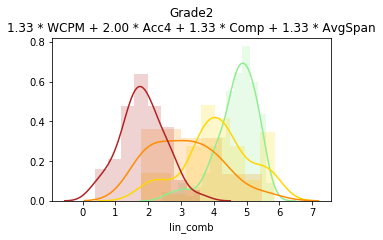

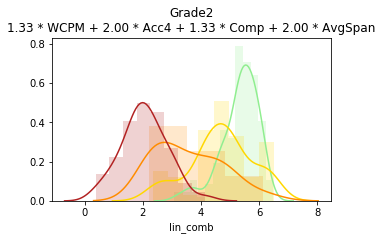

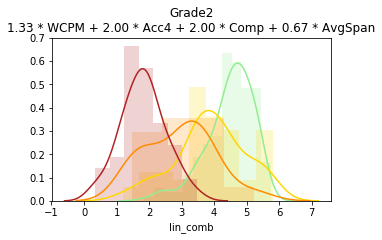

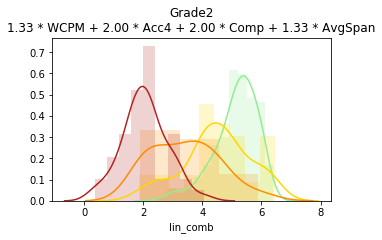

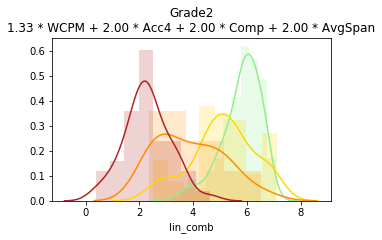

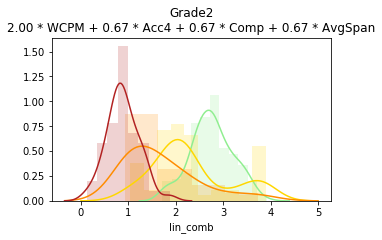

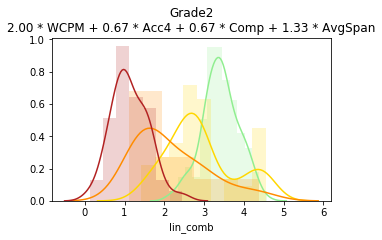

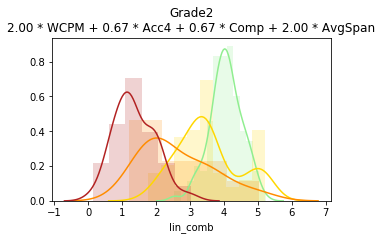

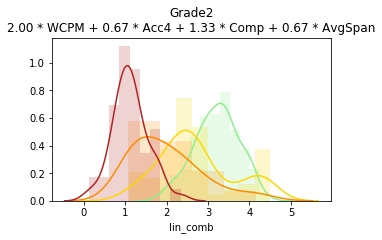

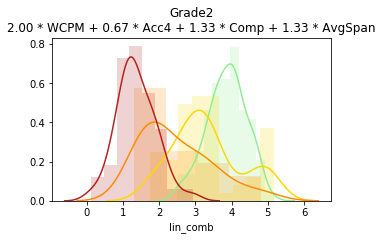

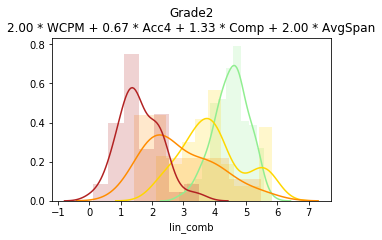

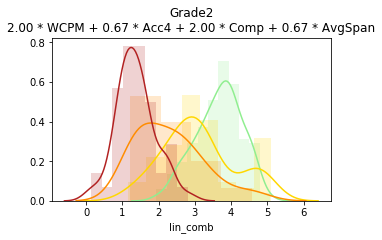

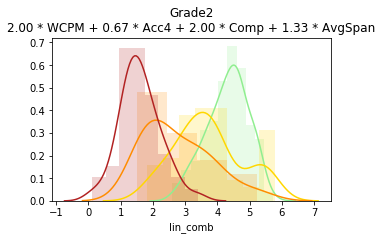

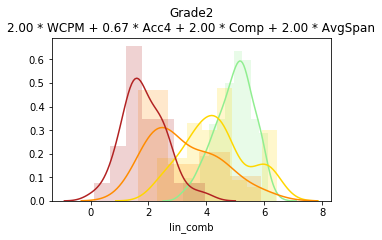

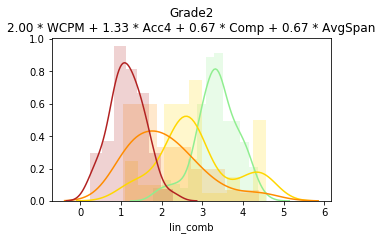

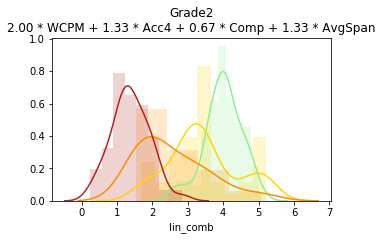

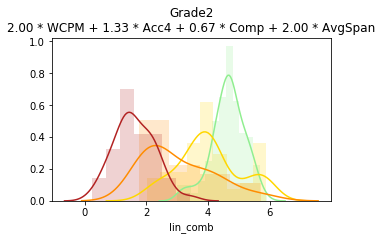

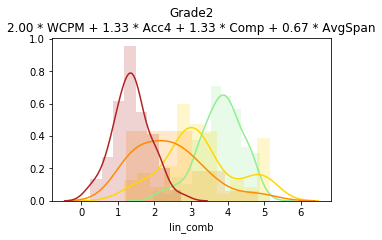

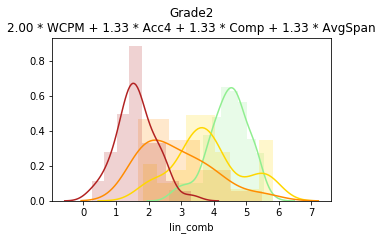

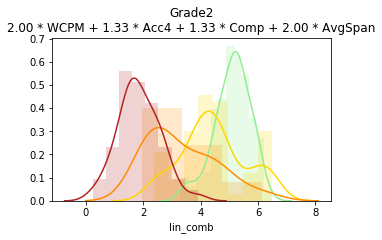

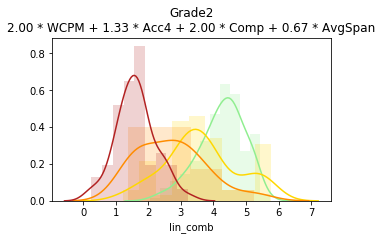

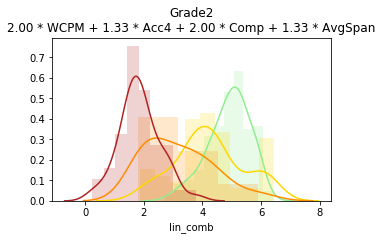

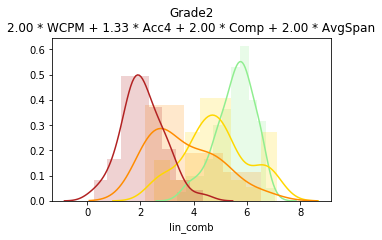

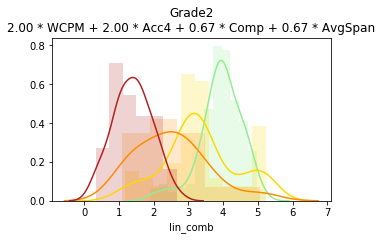

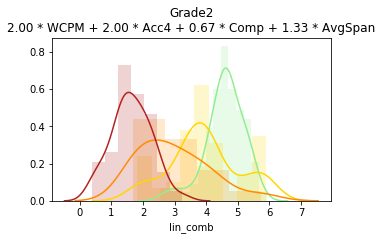

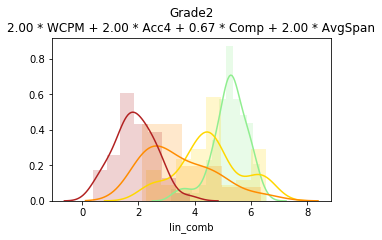

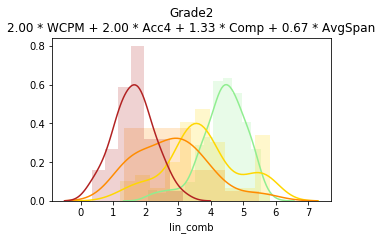

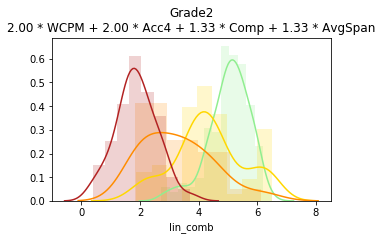

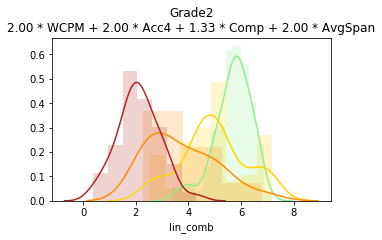

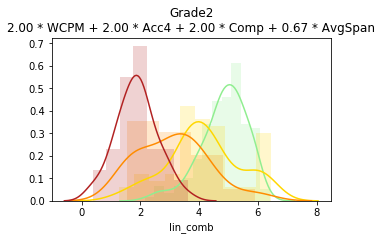

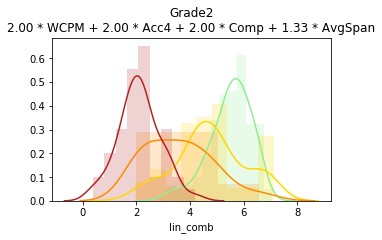

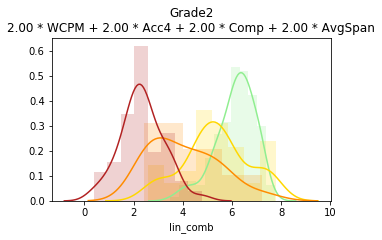

In [6]:
comb_to_average_jaccard = plot_linear_combinations('Grade2', metrics=['WCPM', 'Acc4', 'Comp', 'AvgSpan'], grain=4)
comb_to_average_jaccard

('2.00 * WCPM + 1.33 * Acc4 + 2.00 * Comp + 2.00 * AvgSpan',
 0.11999012709561845)

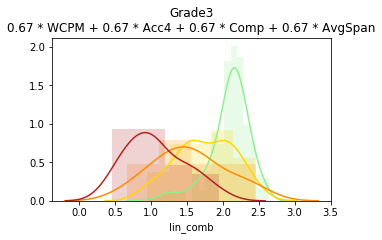

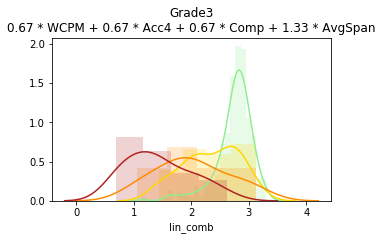

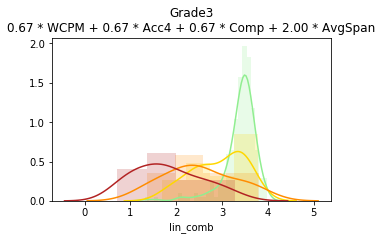

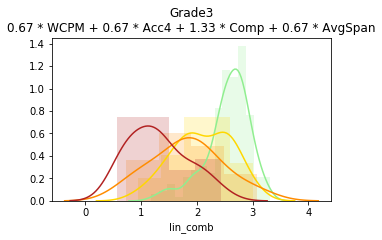

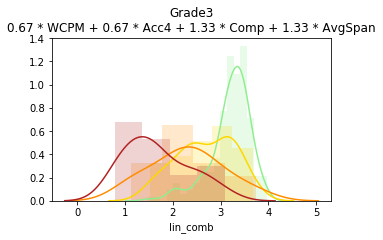

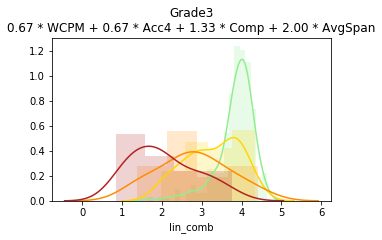

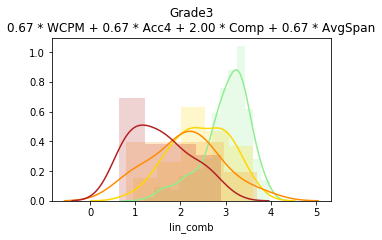

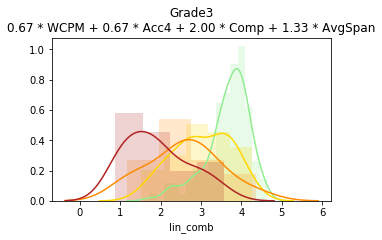

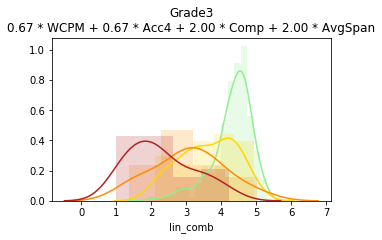

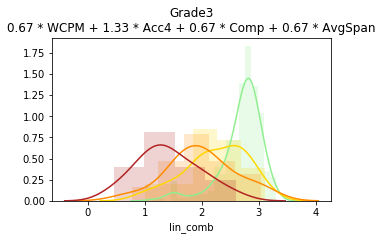

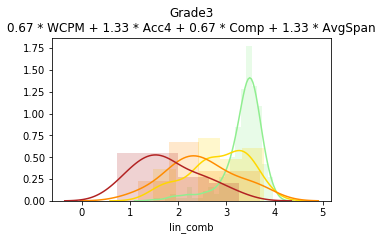

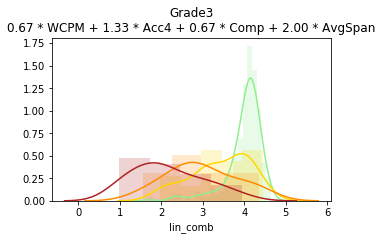

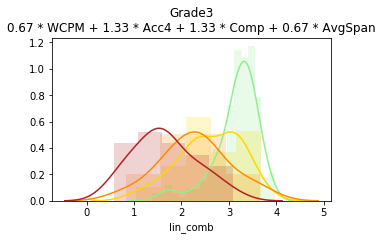

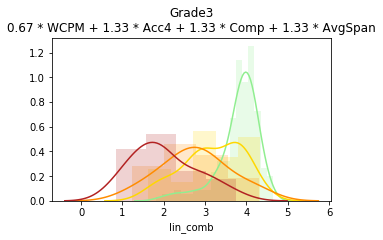

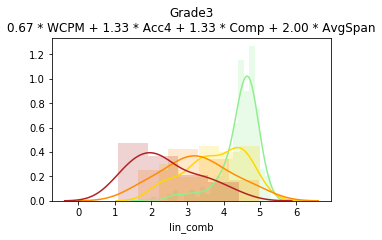

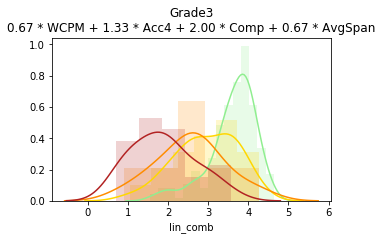

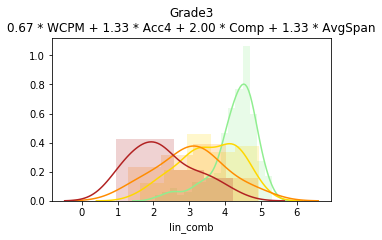

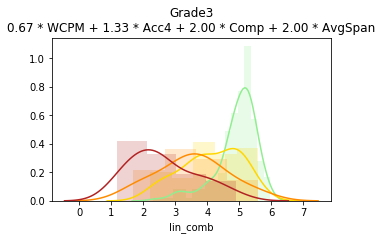

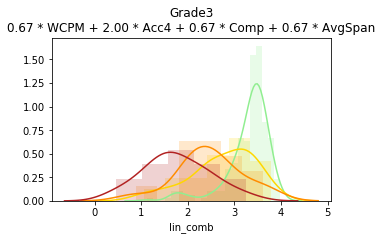

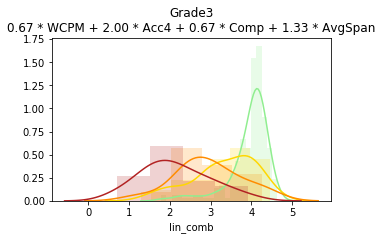

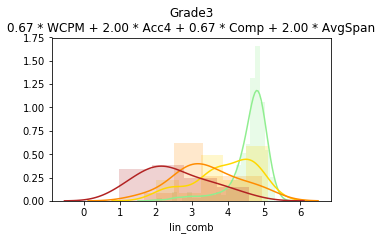

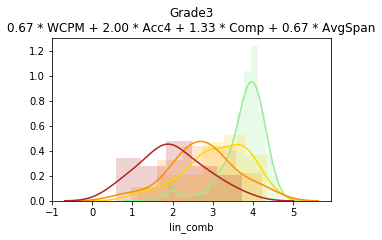

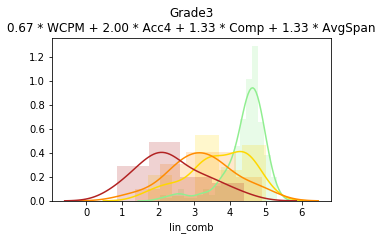

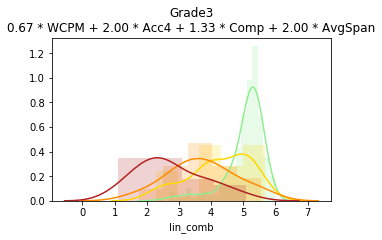

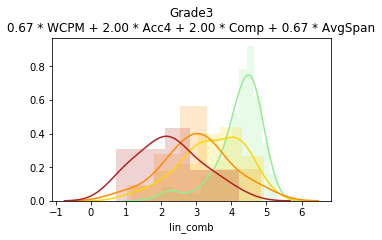

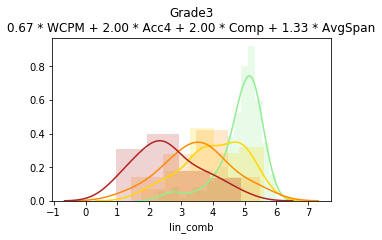

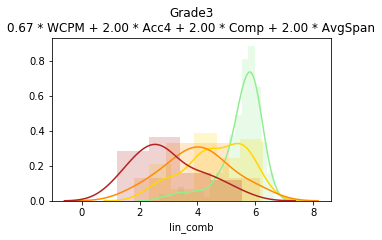

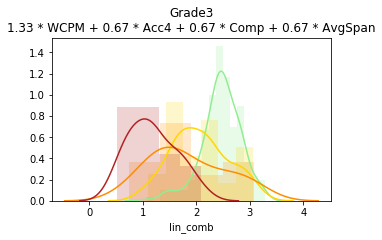

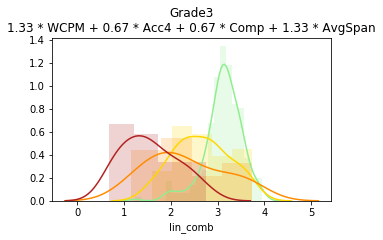

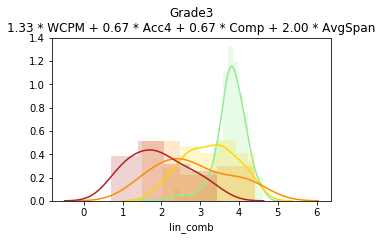

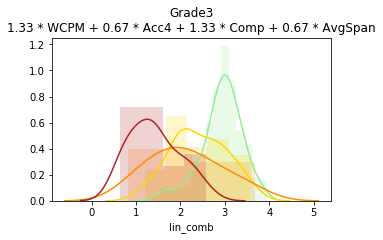

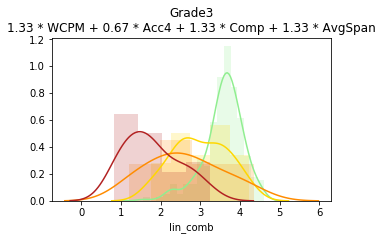

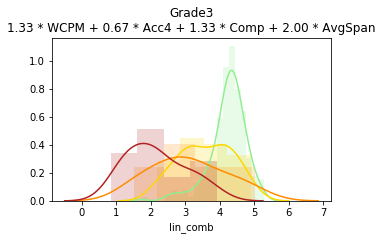

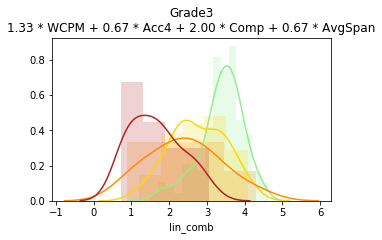

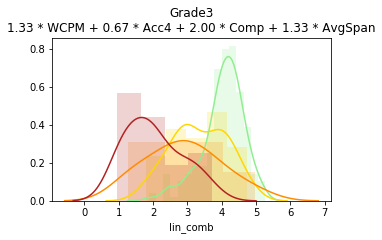

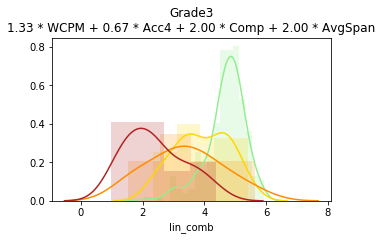

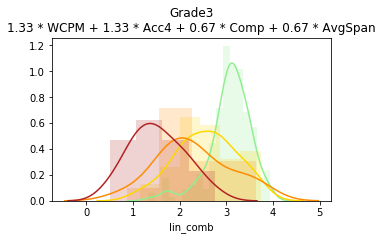

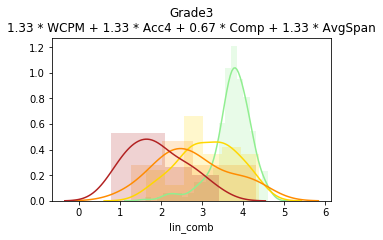

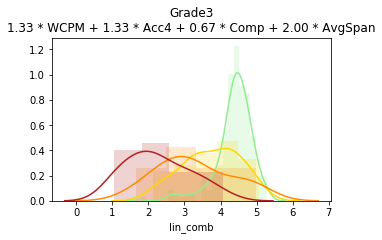

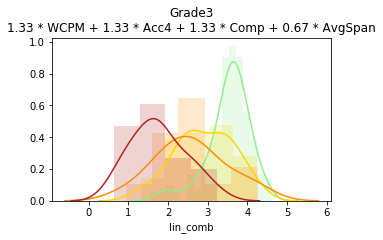

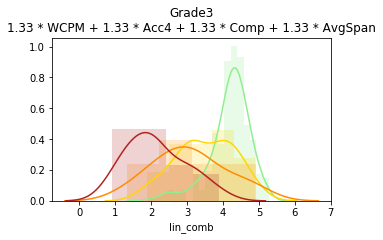

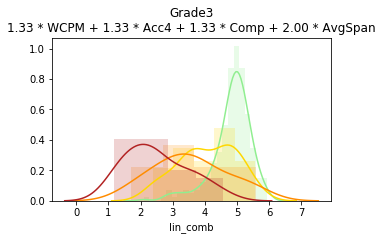

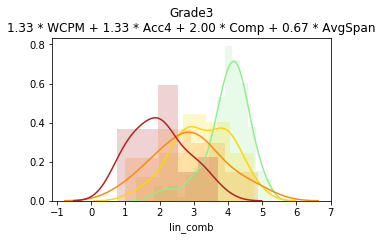

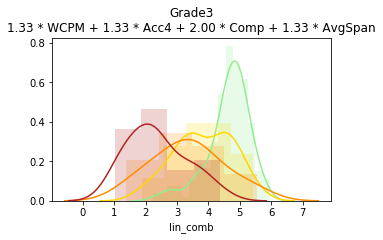

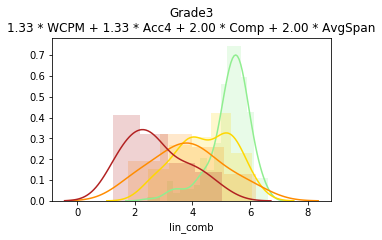

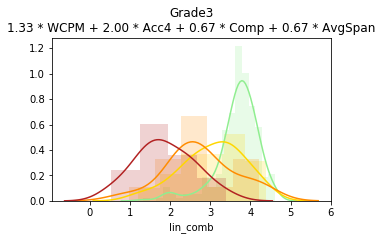

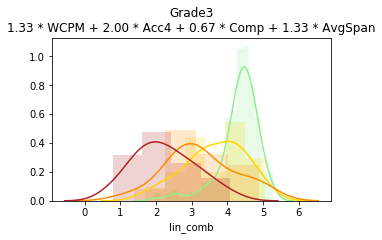

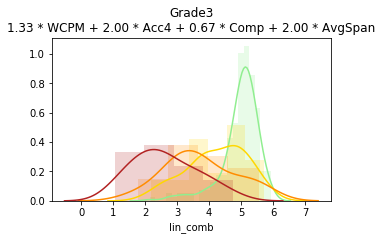

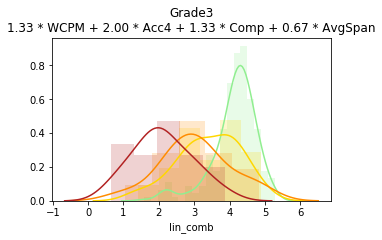

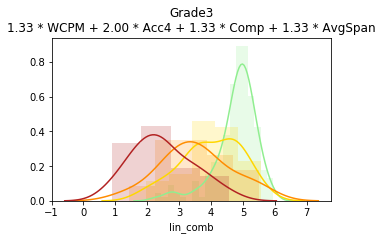

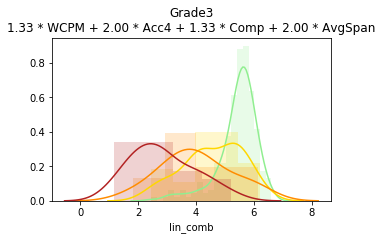

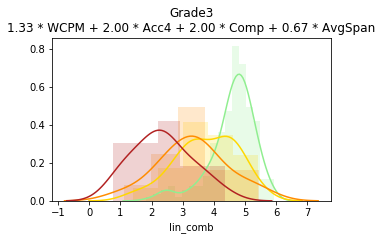

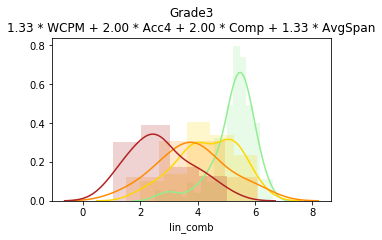

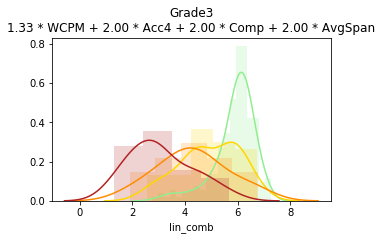

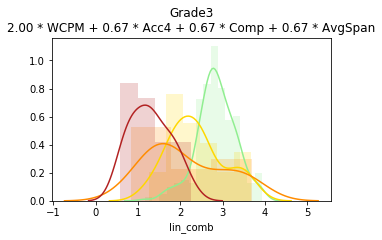

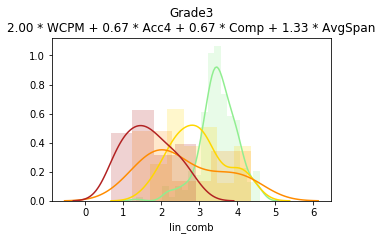

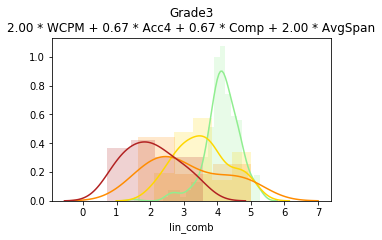

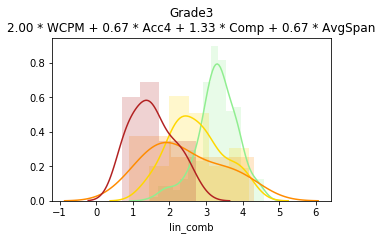

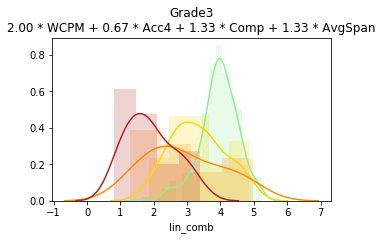

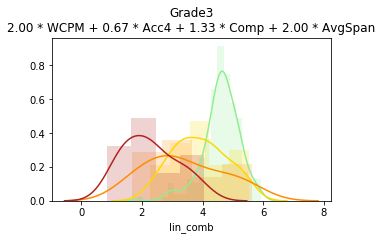

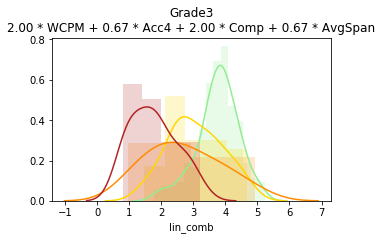

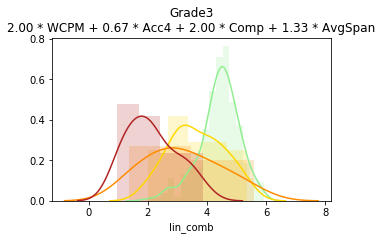

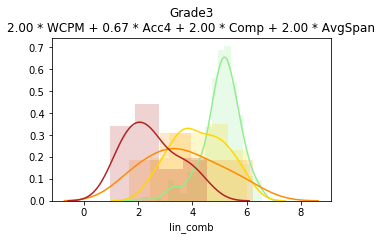

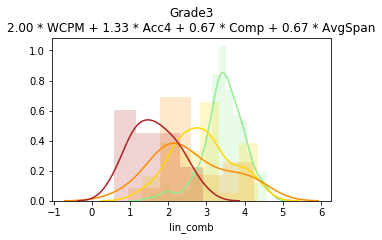

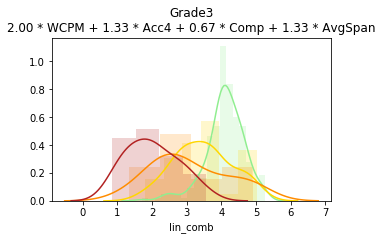

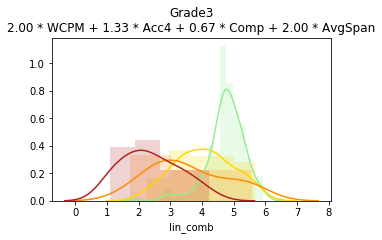

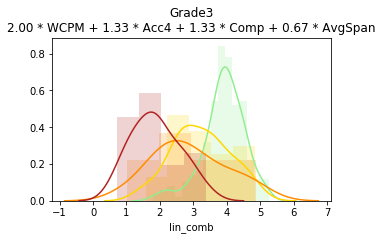

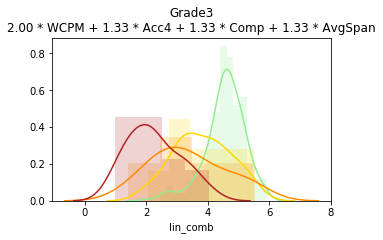

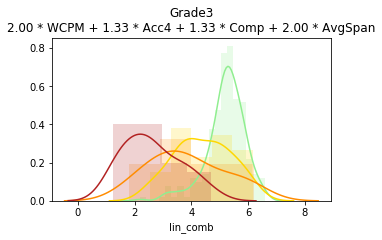

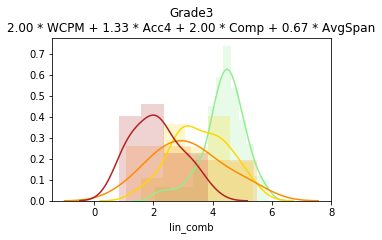

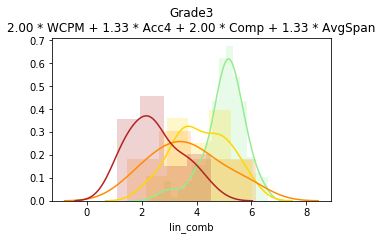

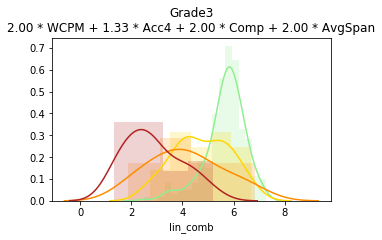

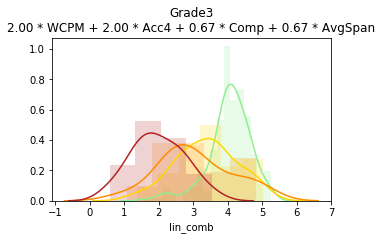

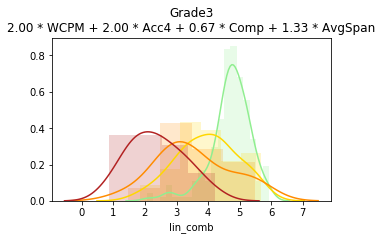

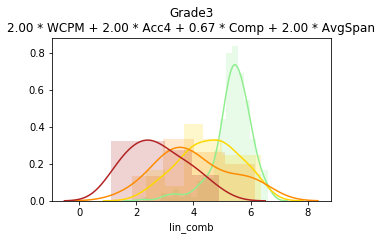

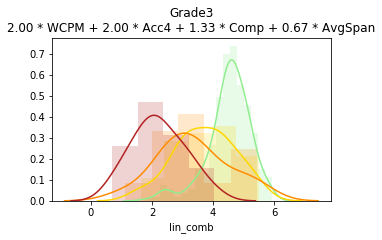

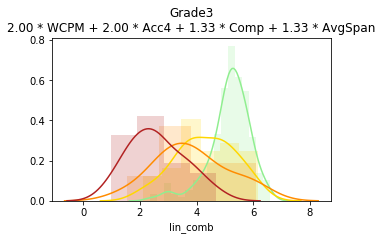

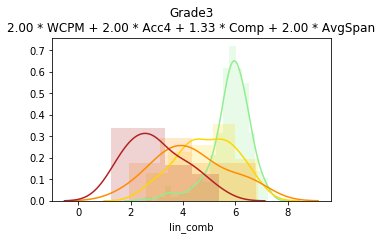

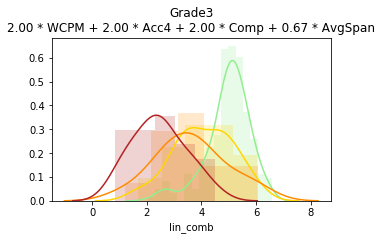

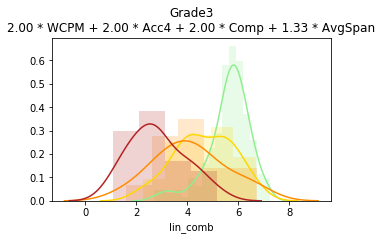

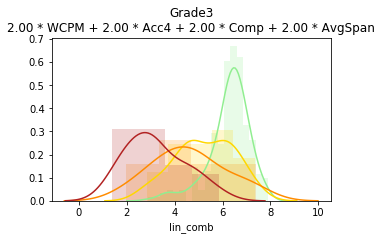

In [7]:
comb_to_average_jaccard = plot_linear_combinations('Grade3', metrics=['WCPM', 'Acc4', 'Comp', 'AvgSpan'], grain=4)
comb_to_average_jaccard

('2.00 * WCPM + 2.00 * Acc4 + 2.00 * Comp + 1.33 * AvgSpan',
 0.1295186941867592)

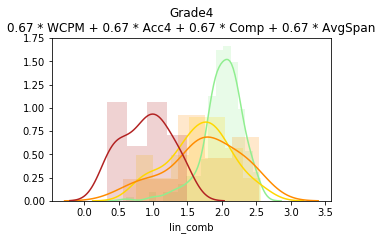

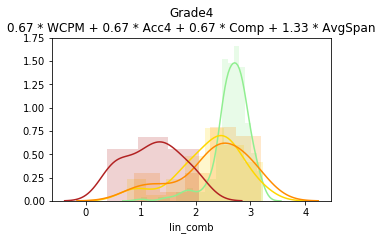

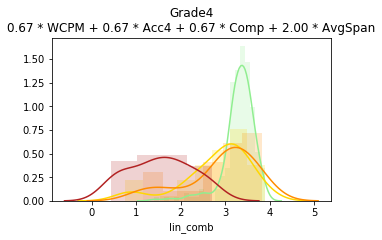

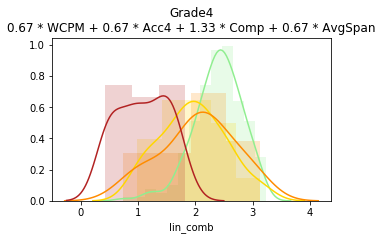

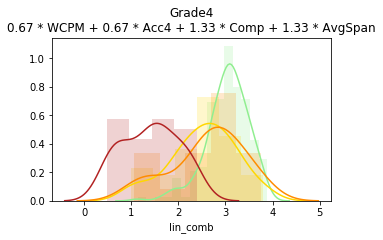

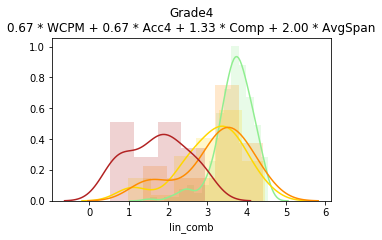

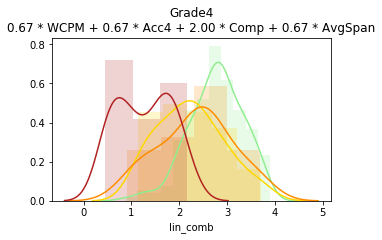

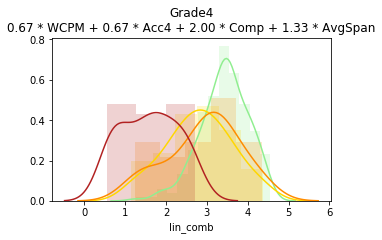

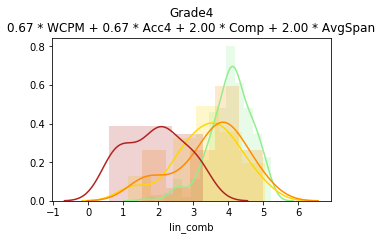

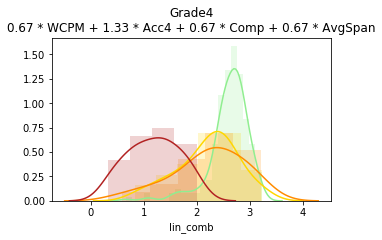

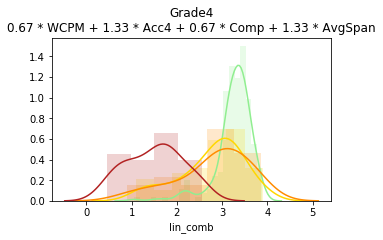

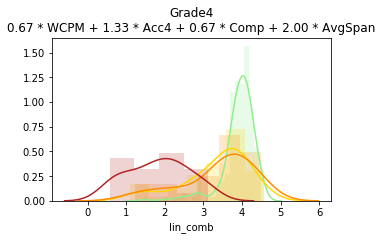

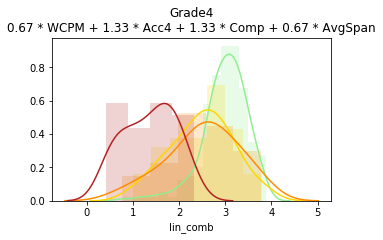

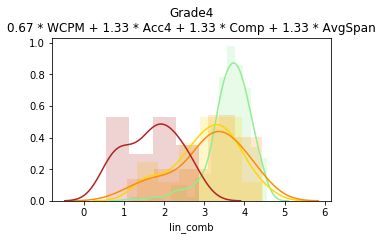

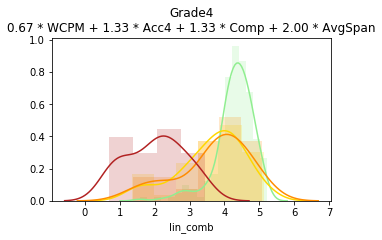

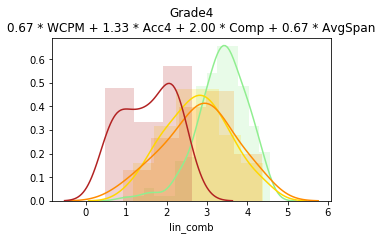

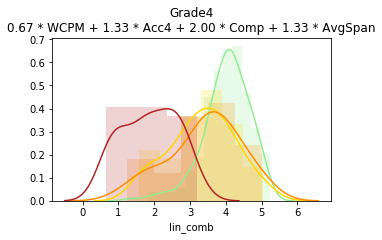

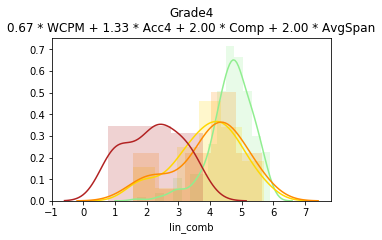

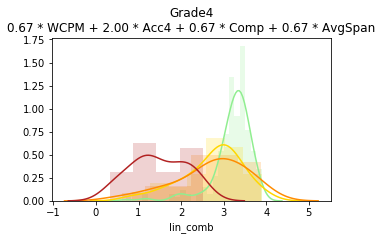

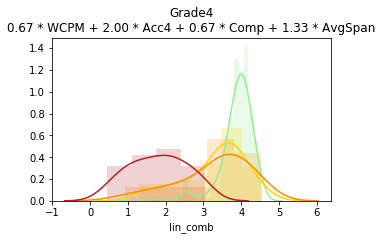

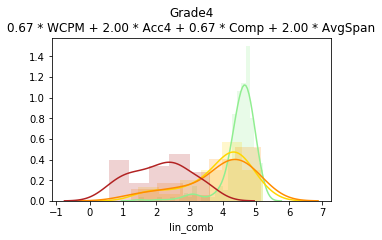

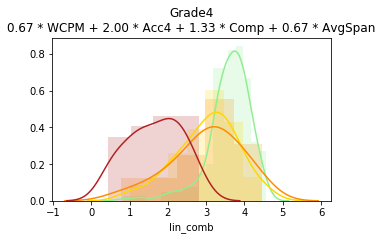

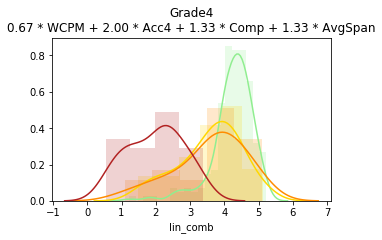

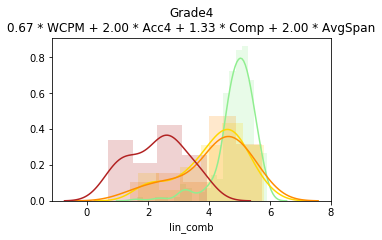

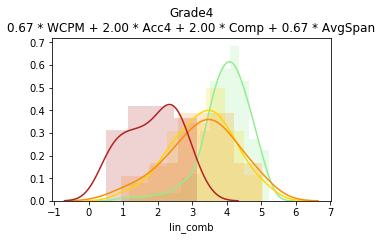

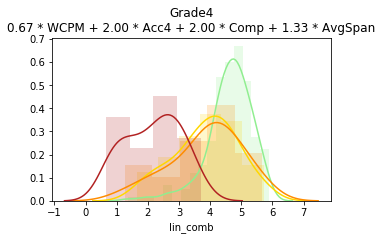

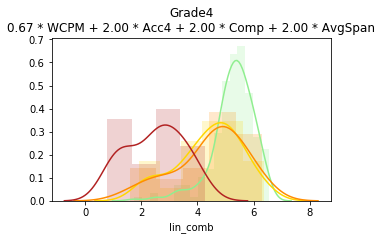

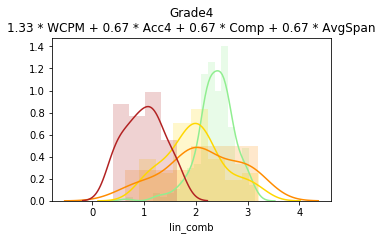

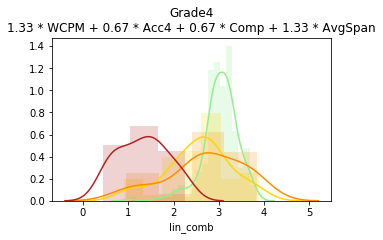

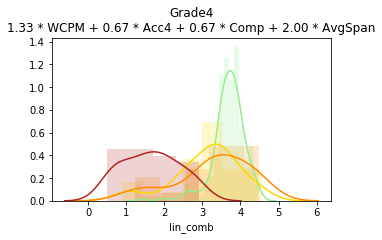

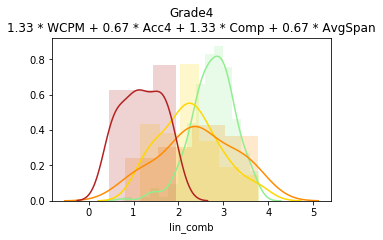

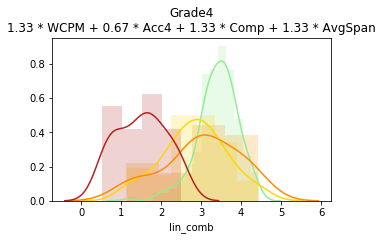

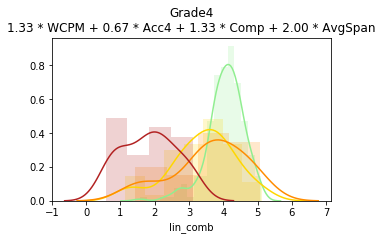

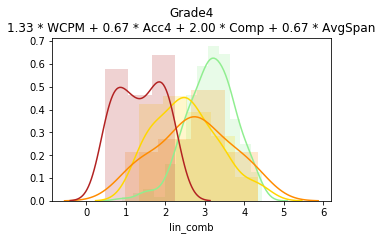

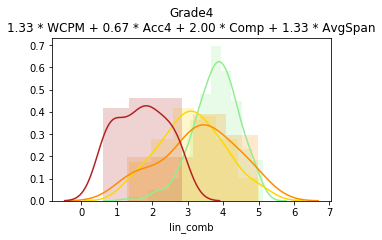

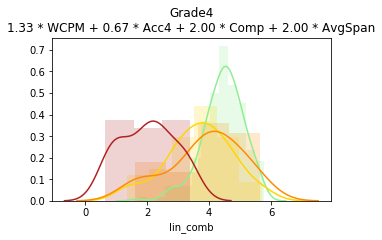

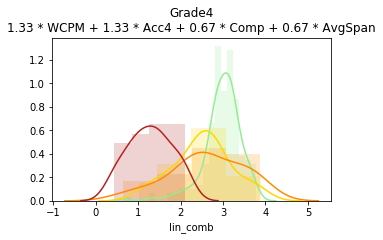

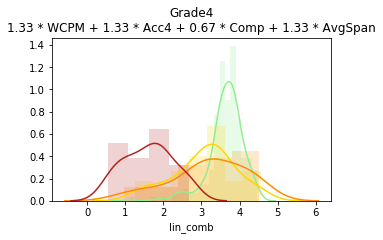

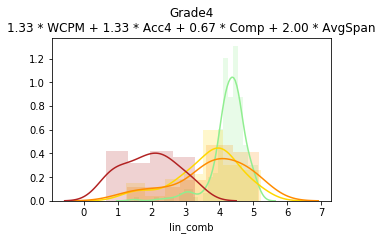

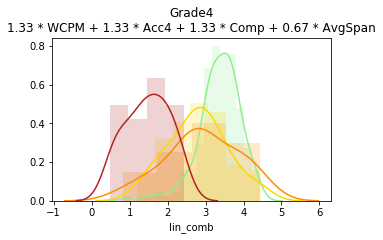

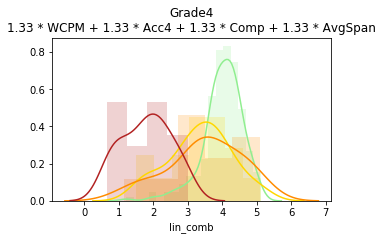

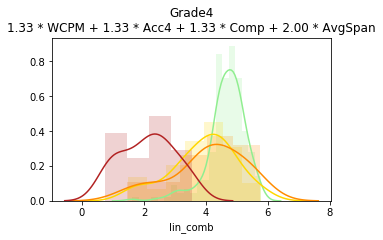

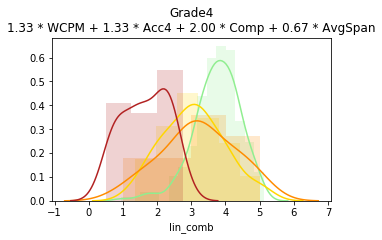

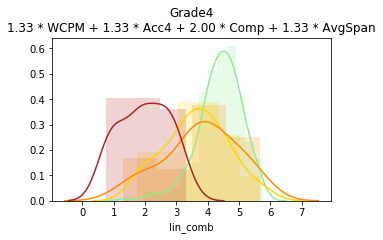

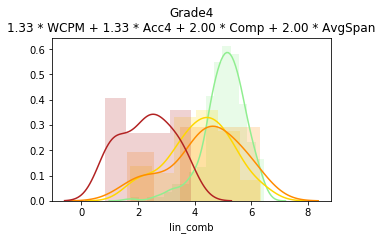

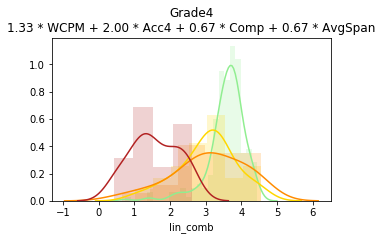

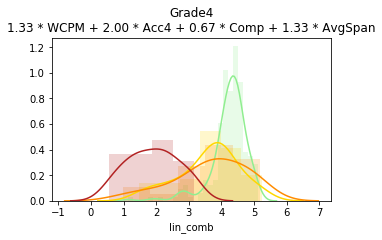

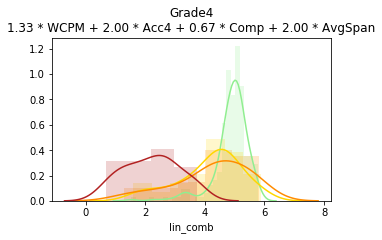

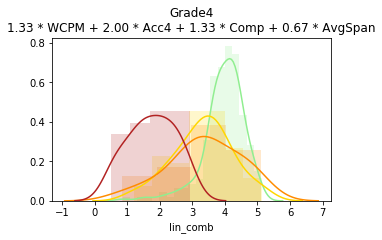

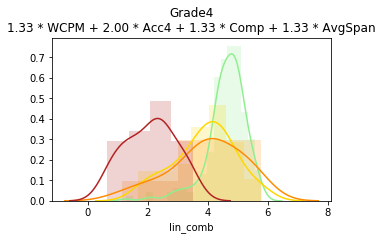

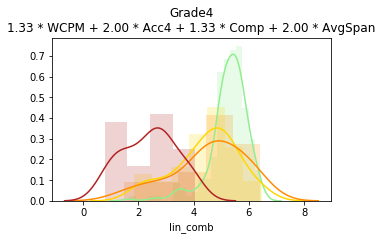

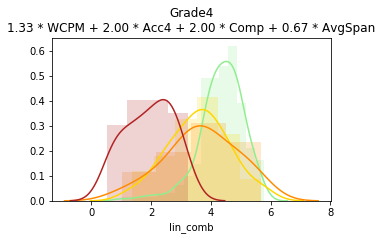

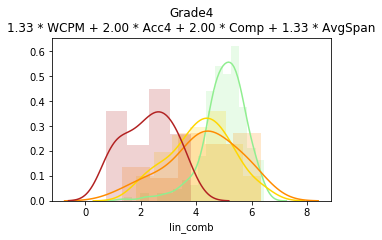

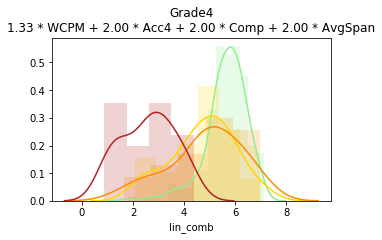

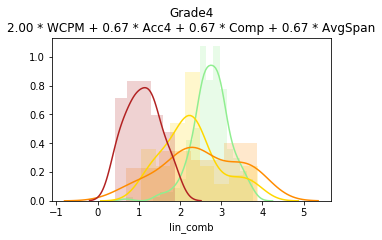

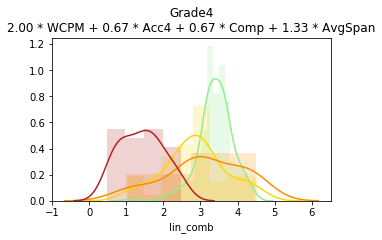

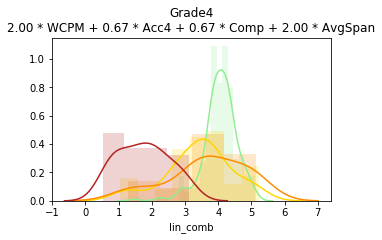

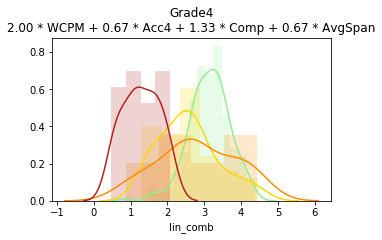

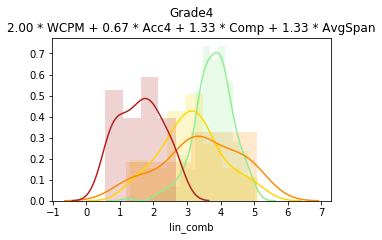

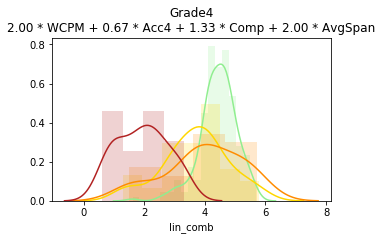

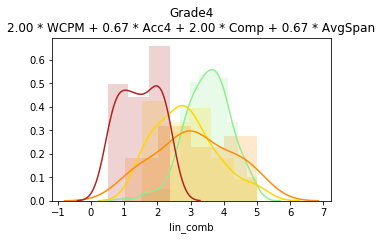

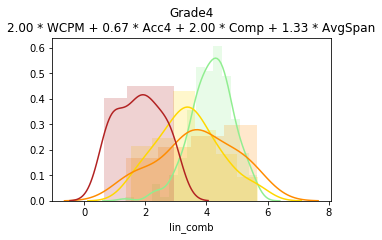

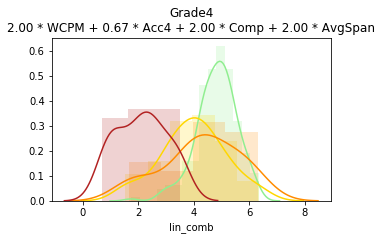

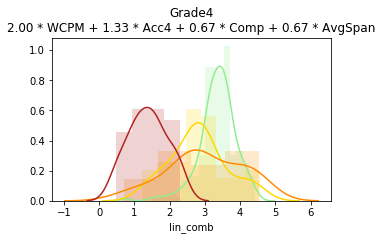

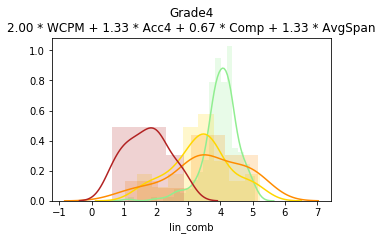

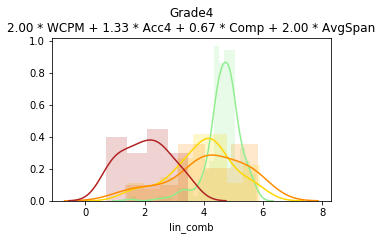

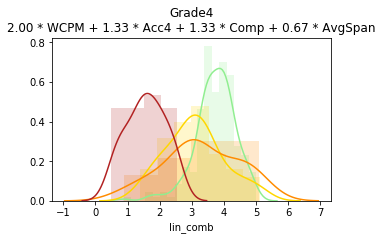

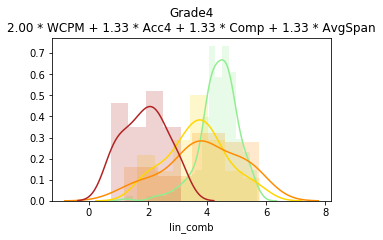

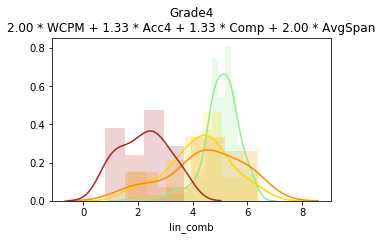

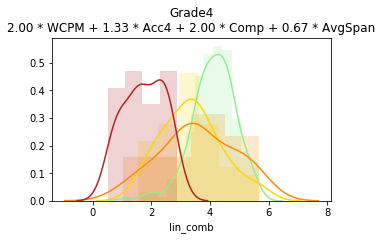

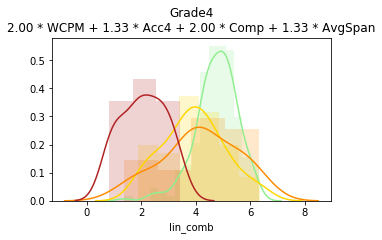

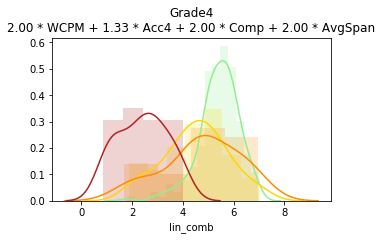

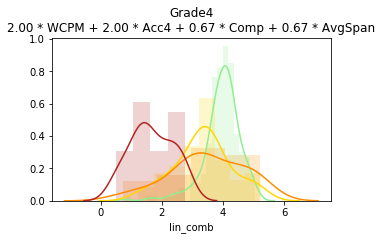

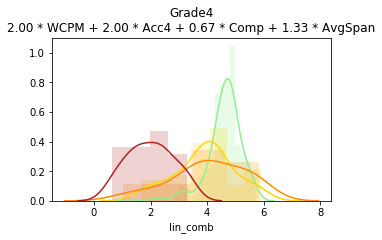

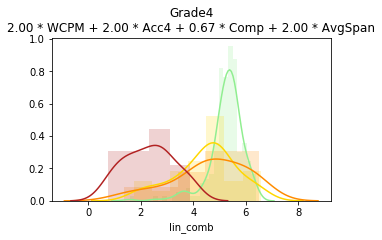

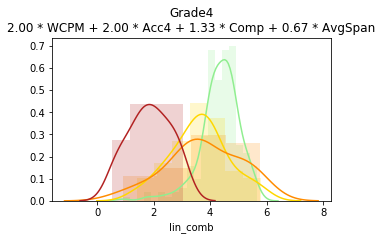

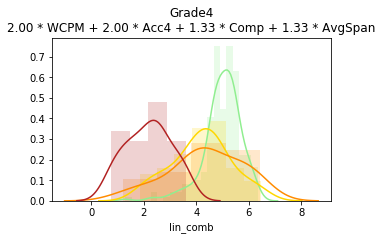

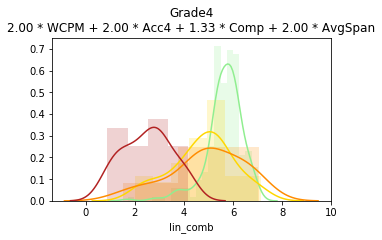

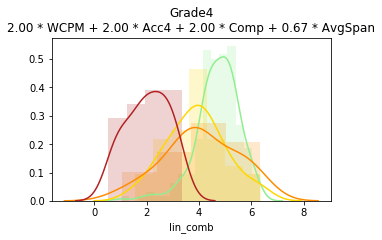

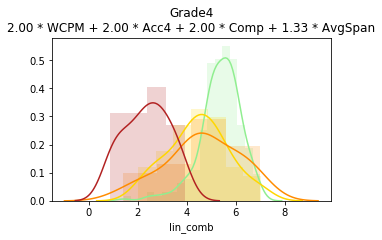

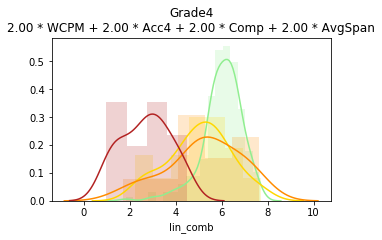

In [8]:
comb_to_average_jaccard = plot_linear_combinations('Grade4', metrics=['WCPM', 'Acc4', 'Comp', 'AvgSpan'], grain=4)
comb_to_average_jaccard